In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import pandas as pd
from mpl_toolkits import mplot3d

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class poly(nn.Module):
    def __init__(self, degree, M):
        super(poly, self).__init__()
        
        self.deg_ = degree
        self.M_ = M
        
        
    def forward(self, z):
            
        P = torch.zeros(z.shape[0])
        N = z.shape[0]
        x = z[:,0]
        t = z[:,1]

        X = torch.zeros((N, 1 + self.deg_))
        T = torch.zeros((N, 1 + self.deg_))

        for i in range(1 + self.deg_):
            X[:, i] = x ** i
            T[:, i] = t ** i


        for i in range(N):
            P[i] = X[i,:] @ self.M_ @ T[i, :]
        return P

In [4]:
class NN(nn.Module):
    def __init__(self, Layers, degree, act = nn.Tanh()):
        super(NN, self).__init__()
        
        self.deg   = degree
        self.M     = nn.Parameter(torch.Tensor(1 + self.deg, 1 + self.deg).normal_(0., .05))
        self.poly_ = poly(self.deg, self.M)
        
        self.act = act
        self.fc  = nn.ModuleList()
        
        for i in range(len(Layers) - 1):
            self.fc.append(nn.Linear(Layers[i], Layers[i+1]))
            
    def forward(self, x):
        for i in range(len(self.fc)-1):
            x = self.fc[i](x)
            x = self.act(x)
        x = self.fc[-1](x)
        return x
    
    def R(self, x):
        return (self(x) * self.poly_(x)).mean()**2

In [5]:
class Net():
    def __init__(self, x, u, xx, layers, degree, activation = nn.Tanh(), n_ep = 1000):
        
        
        self.n_ep      = n_ep
        self.x         = x.clone().detach().requires_grad_(False)
        self.xx        = xx.clone().detach().requires_grad_(True)
        
        perm           = torch.randperm(x.size(0))
        idx            = perm[:20]
        self.zz        = xx[idx].clone().detach().requires_grad_(False)
        
        
        self.u         = u
        
        self.n_layers  = len(layers)
        self.act       = activation
        self.u_net     = NN(layers, degree, self.act)
        
        self.His_loss  = []
        self.His_acc  = []
    
        
        
    def get_loss(self):
        
        y_hat   = self.u_net(self.x)
            
        loss_1 = (y_hat - self.u).square().mean()

#         u_hat   = y_hat + self.u_net.poly_(self.x)
#         loss_1  = (u_hat - self.u).square().mean()


        
#         yy      = self.u_net(self.xx)
#         uu      = yy + self.u_net.poly_(self.xx)

        uu = self.u_net(self.xx)
               
        
        du_hat = torch.autograd.grad(uu.sum(), self.xx, create_graph=True)[0]
#         du_hat, = torch.autograd.grad(uu,
#                             self.xx,
#                             create_graph=True,
#                             retain_graph=True,
#                             grad_outputs=torch.ones(uu.shape))
        

        loss_2 = (du_hat[:,0] + du_hat[:,1] - 3*self.xx[:,0] - self.xx[:,1]).square().mean()
    
#         loss_3 = self.u_net.R(self.zz)
        
        return loss_1 + loss_2 #+ loss_3
        
        
    def train(self, X_star = None, u_star = None):    
        optimizer = torch.optim.SGD(self.u_net.parameters(), lr = 5e-4, momentum = 0.95)
#         optimizer = torch.optim.Adam(self.u_net.parameters(), lr=5e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=.9)
        for n in range(self.n_ep):
            
            loss = self.get_loss()
            with torch.no_grad():
                
                _y_hat_ = self.u_net(Z)
                _u_hat_ = _y_hat_.reshape(-1,)
                self.His_acc.append((_u_hat_ - y).square().sum()/200)
                
                self.His_loss.append(loss.item())
                
            if n % 100 == 0:
                print(n)
                with torch.no_grad():
                    print(loss.item())
                    
                    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

In [6]:
def boundary(x):
    return x[:,0]**2 + x[:,0]*x[:,1]

In [7]:
# Z = torch.zeros(200,2)

In [8]:
# Z[:, 0] = torch.Tensor(200).uniform_(-1., 1.)
# Z[:, 1] = torch.Tensor(200).uniform_(-1., 1.)
# y = boundary(Z)

In [9]:
# y = 1/(1+25*Z[:, 0]**2)

In [10]:
Layers = [2, 100, 1]

In [11]:
k =330
a = torch.linspace(-1, 1, steps=k)
b = torch.linspace(-1, 1, steps=k)
grid_x, grid_y = torch.meshgrid(a, b, indexing='ij')
XX = torch.zeros((k**2, 2))
XX[:,0] = grid_x.reshape(-1)
XX[:,1] = grid_y.reshape(-1)

In [12]:
perm     = torch.randperm(XX.size(0))
idx      = perm[:200]
Z        = XX[idx]
y = boundary(Z)

In [13]:
Z.shape

torch.Size([200, 2])

In [14]:
#Z

In [15]:
model = Net(Z, y, XX, Layers, 2)

In [16]:
beta = 1

In [17]:
model.train()

0
3.533155918121338
100
0.9179688692092896
200
0.5546848773956299
300
0.5030392408370972
400
0.47643887996673584
500
0.4591221213340759
600
0.4453886151313782
700
0.43516629934310913
800
0.4264485239982605
900
0.4196266531944275


In [18]:
y_hat = model.u_net(Z)
u_hat = y_hat.reshape(-1,) #+ model.u_net.poly_(Z)
print((u_hat - y).square().sum()/200)

tensor(0.0020, grad_fn=<DivBackward0>)


In [19]:
import matplotlib.pyplot as plt

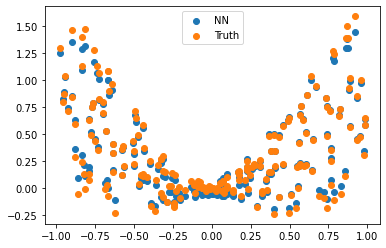

In [20]:
plt.scatter(Z[:, 0].detach().numpy(), u_hat.detach().numpy(), label = 'NN')
plt.scatter(Z[:, 0].detach().numpy(), y.detach().numpy(), label = "Truth")
plt.legend()
plt.show()

In [21]:
W = Z + 0
W[:,1] =1
#W

In [22]:
y_ = boundary(W)

In [23]:
y_hat_ = model.u_net(W)
u_hat_ = y_hat_.reshape(-1,) #+ model.u_net.poly_(W)
print((u_hat_ - y_).square().sum()/1000)

tensor(0.0021, grad_fn=<DivBackward0>)


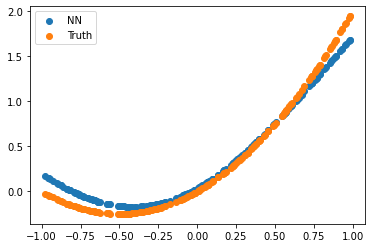

In [24]:
plt.scatter(W[:, 0].detach().numpy(), u_hat_.detach().numpy(), label = 'NN')
plt.scatter(W[:, 0].detach().numpy(), y_.detach().numpy(), label = "Truth")
plt.legend()
plt.show()

In [25]:
a = torch.linspace(-1, 1, steps=100)
b = torch.linspace(-1, 1, steps=100)
grid_x, grid_y = torch.meshgrid(a, b, indexing='ij')

In [26]:
XX = torch.zeros((10000, 2))
XX[:,0] = grid_x.reshape(-1)
XX[:,1] = grid_y.reshape(-1)

In [27]:
y_hat_ = model.u_net(XX)
u_hat_ = y_hat_.reshape(-1,) #+ model.u_net.poly_(XX)

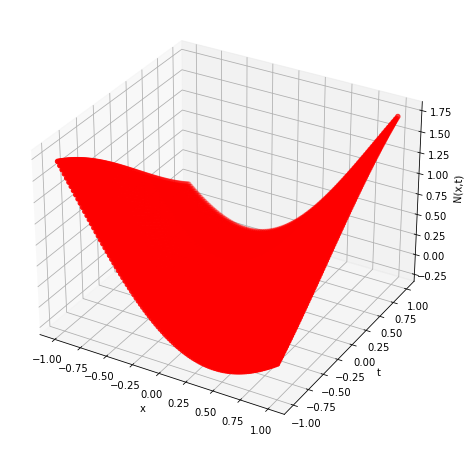

In [28]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_y, u_hat_.detach().numpy(), color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('N(x,t)')
plt.show()

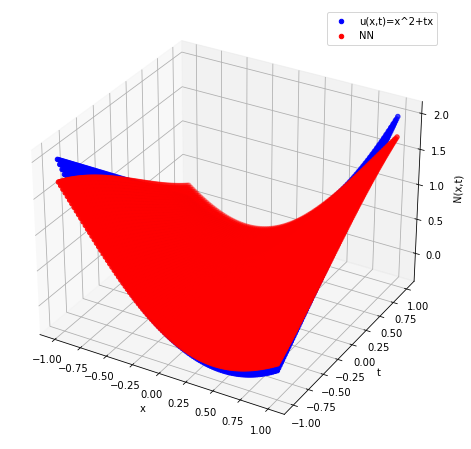

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_y,(grid_x**2 + grid_x*grid_y), label = 'u(x,t)=x^2+tx', color = 'b')
ax.scatter3D(grid_x, grid_y, u_hat_.detach().numpy(), label = 'NN', color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('N(x,t)')
plt.legend()
plt.show()

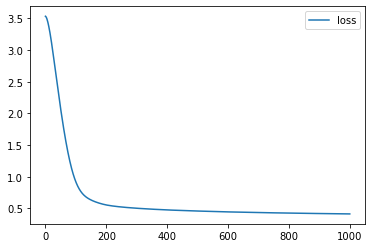

In [32]:
plt.plot(model.His_loss, label = "loss")
plt.legend()
plt.show()

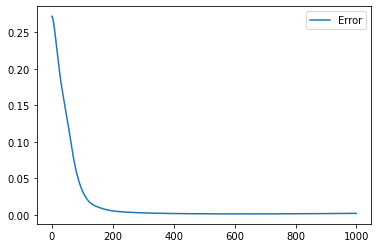

In [34]:
plt.plot(model.His_acc, label = "Error")
plt.legend()
plt.show()